### Анализ популярных направлений по данным Aviasales в период майских праздников (30 апреля — 9 мая)

**Описание**:

Целью исследования является анализ влияния города отправления на стоимость авиабилетов по популярным направлениям в период майских праздников, а также выявление взаимосвязи между видами отдыха и ценами на билеты, чтобы определить ключевые факторы, влияющие на выбор туристических направлений у российских путешественников. Данные получены с AviaSales — ведущего метапоисковика авиабилетов, обрабатывающего предложения 800+ авиакомпаний и 200+ ticket-агентств. Они регулярно собирают статистику по популярности разных направлений и публикуют её в специальном разделе на их сайте. Мы решили использовать эти данные и проанализировать поведение туристов во время майских праздников (30 апреля - 9 мая)

In [31]:
# ячейка для импортов модулей проекта
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import geopandas as gpd
import folium
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Загрузка данных

In [32]:
# загружаем файл
df = pd.read_csv('../data/popular_destinations_9may.csv')
print(df.head())

  destination_city destination_country      origin_name     price
0          Коломбо           Шри-Ланка           Москва  13869.00
1          Коломбо           Шри-Ланка     Екатеринбург  21891.00
2          Коломбо           Шри-Ланка              Уфа  20351.41
3          Коломбо           Шри-Ланка  Санкт-Петербург  19929.00
4          Коломбо           Шри-Ланка            Дубай   8236.00


В данном разделе выполните выгрузку данных из внешних источников и их локальное сохранение

Вы можете вынести всю логику выгрузки в отдельный `.py` скрипт (или набор скриптов), поместив их в директорию `scripts` в корне проекта, но продублируйте весь код здесь тоже, чтобы можно было запустить ноутбук с самого начала

## Очистка данных и подготовка к анализу

Посмотрим на тип данных и пропуски в каждом столбце:

In [33]:
print(df.dtypes)
print(df.isnull().sum())

destination_city        object
destination_country     object
origin_name             object
price                  float64
dtype: object
destination_city       0
destination_country    0
origin_name            0
price                  0
dtype: int64


destination_city, destination_country и origin_name — текстовые данные (тип object), предназначенные для хранения текстовой информации. price — числовой тип (float64), подходящий для хранения цен. В данных нет пропущенных значений (NaN), все столбцы заполнены. Это значит, что данные полные и не требуют предварительной обработки. Для анализа можно сразу перейти к исследованию распределений, расчету статистических показателей и визуализации

Проанализируем данные из каждого столбца.
Начнем с анализа числовых переменных: price(цена авиабилета)

In [34]:
print("анализ цены:")
print(df['price'].describe())

анализ цены:
count      118.000000
mean     18133.239576
std      11667.991728
min       1057.000000
25%       8964.000000
50%      15777.500000
75%      23943.750000
max      54792.340000
Name: price, dtype: float64


В столбце с ценами *118* записей, что соответствует общему количеству билетов, пропусков не обнаружено. Средняя цена билета — около *18 133* рублей. Стандартное отклонение — примерно *11 667* рубль, что указывает на достаточно большую вариацию цен. Самая низкая цена — *1 057* рублей, а 25% билетов стоят не дороже *8 964* рубля. Медиана — *15 777* рублей, что достаточно близко к среднему. 75% билетов стоят не дороже *23 943* рублей, а максимальная цена — *54 792* рубля. Это значение можно отнести к выбросам в данных с аналитической точки зрения, но если вспомнить, что анализируются цены на билеты, которые очень сильно различаются в зависимости от направления и других внешних факторов, то можно сделать вывод, что и это значение цены нормально. Разница между средним и медианой небольшая по сравнению со стандартным отклонением (около *2 356* рублей), что указывает на близкое к симметричному распределение данных.

Далее посмотрим на **Boxplot** и **гистограмму**, чтобы убедиться в правильности наших выводов

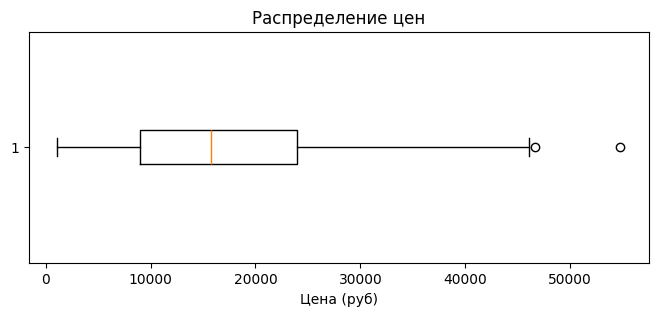

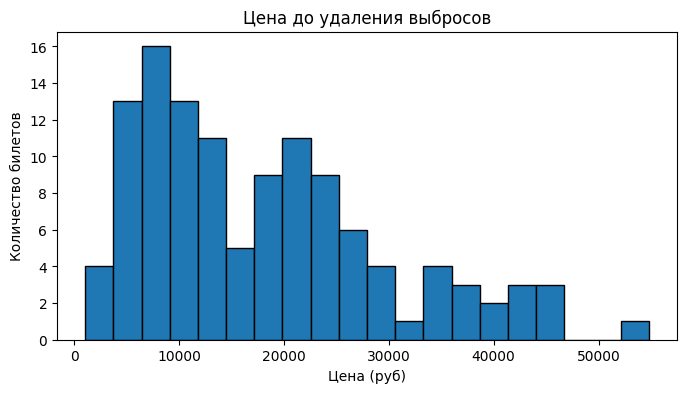

In [35]:
#графики для данных до очистки выбросов
#boxplot
plt.figure(figsize=(8, 3))
plt.boxplot(df['price'], vert=False)
plt.title('Распределение цен')
plt.xlabel('Цена (руб)')
plt.show()
#гистограмма
plt.figure(figsize=(8, 4))
plt.hist(df['price'], bins=20, edgecolor='black')
plt.title('Цена до удаления выбросов')
plt.xlabel('Цена (руб)')
plt.ylabel('Количество билетов')
plt.show()

Если выбросы есть, то почистим их, также посмотрим сколько их было

In [36]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR  # нижняя граница
upper_bound = Q3 + 1.5 * IQR  # верхняя граница

clean_df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)].copy()

print(f"Исходное количество данных: {len(df)}")
print(f"Осталось после очистки: {len(clean_df)}")
print(f"Удалено выбросов: {len(df) - len(clean_df)}")

Исходное количество данных: 118
Осталось после очистки: 116
Удалено выбросов: 2


Посмотрим на данные после удаления выбросов

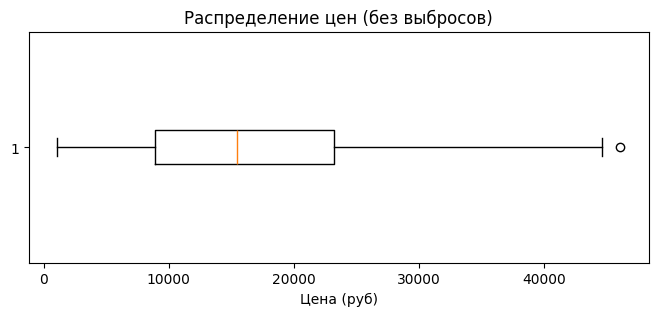

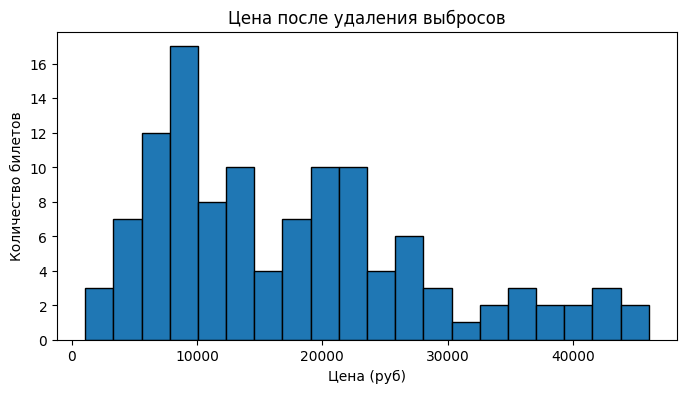

In [37]:
#boxplot
plt.figure(figsize=(8, 3))
plt.boxplot(clean_df['price'], vert=False)
plt.title("Распределение цен (без выбросов)")
plt.xlabel("Цена (руб)")
plt.show()
#гистограмма
plt.figure(figsize=(8, 4))
plt.hist(clean_df['price'], bins=20, edgecolor='black')
plt.title('Цена после удаления выбросов')
plt.xlabel('Цена (руб)')
plt.ylabel('Количество билетов')
plt.show()


Проверим нормальность распределения с помощью построения Q-Q графика

Text(0.5, 1.0, 'Q-Q график')

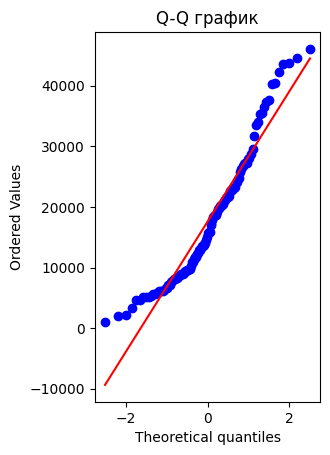

In [38]:
plt.subplot(1, 2, 2)
stats.probplot(clean_df['price'], dist="norm", plot=plt)
plt.title('Q-Q график')

 Данные распределены ненормально.

Добавим в таблицу столбец с названием вида отдыха в зависимости от места назначения, чтобы в дальнейшем пронализировать, какой вид отдыха самый выгодный


In [39]:
destinations_to_rest = {
    'Мале': 'Пляжный отдых',
    'Дубай': 'Пляжный отдых',
    'Варадеро': 'Пляжный отдых',
    'Маврикий': 'Пляжный отдых',
    'Ташкент': 'Культурный отдых',
    'Стамбул': 'Культурный отдых',
    'Белград': 'Культурный отдых',
    'Токио': 'Культурный отдых',
    'Коломбо': 'Городской отдых',
    'Бангкок': 'Городской отдых',
    'Манила': 'Городской отдых',
    'Подгорица': 'Городской отдых',
}

df['Type_of_rest'] = df['destination_city'].map(destinations_to_rest)
print(df.head())
df.to_csv('../data/final_dataframe.csv', index=False)

  destination_city destination_country      origin_name     price  \
0          Коломбо           Шри-Ланка           Москва  13869.00   
1          Коломбо           Шри-Ланка     Екатеринбург  21891.00   
2          Коломбо           Шри-Ланка              Уфа  20351.41   
3          Коломбо           Шри-Ланка  Санкт-Петербург  19929.00   
4          Коломбо           Шри-Ланка            Дубай   8236.00   

      Type_of_rest  
0  Городской отдых  
1  Городской отдых  
2  Городской отдых  
3  Городской отдых  
4  Городской отдых  


## Анализ и визуализация

In [40]:
print("анализ пункта назначения:")
print(df['destination_city'].describe())

анализ пункта назначения:
count         118
unique         12
top       Коломбо
freq           10
Name: destination_city, dtype: object


Заметим, что в обоих случаях 118 значений, пропусков не обнаружено. Destination имеет 12 уникальных значений, самое популярное в представленном датасете - Коломбо (город на острове Шри-Ланка)Коломбо стабильно входит в число самых популярных направлений для перелётов у россиян особенно в период майских праздников. В это время спрос на город особенно высок благодаря сочетанию комфортного климата, удобного авиасообщения и возможности выгодно совместить пляжный отдых с насыщенной экскурсионной программой. Развитая инфраструктура, электронная виза и большое количество турпакетов делают Коломбо доступным и привлекательным выбором для коротких весенних каникул. Дополнительным преимуществом становится возможность легко комбинировать поездку с посещением Мальдив, что ещё больше повышает интерес к этому направлению в майские праздники.

In [41]:
print("анализ места отправления:")
print(df['origin_name'].describe())

анализ места отправления:
count        118
unique        43
top       Москва
freq          12
Name: origin_name, dtype: object


Заметим, что в обоих случаях 118 значений, пропусков не обнаружено. Origin имеет 43 уникальных значений, что означает, что в разные точки назначения представлено разное количество популярных мест отправления. В наибольшее количество мест назначения улетают из Москвы.

 Это может быть связано с тем, что Москва — главный авиационный хаб России, отправная точка для множества направлений. Это крупнейший авиаузел с тремя международными аэропортами (Шереметьево, Домодедово, Внуково), обеспечивающий связь с сотнями городов. Географическое положение в центре транспортной сети делает Москву идеальным пересадочным пунктом. В столице проживает платежеспособное население, сосредоточены бизнес-центры и штаб-квартиры авиакомпаний, что стимулирует спрос на авиаперелеты.  Москва — лидер по туристическому потоку благодаря развитой сети туроператоров и культуре путешествий. Логистические преимущества включают максимальное количество прямых рейсов, оптимальные стыковки и стабильную частоту полетов.  Исторически Москва сохранила статус главного транспортного узла, и большинство международных авиакомпаний открывают рейсы именно здесь, что увеличивает количество направлений. Все это делает столицу лидером по количеству авиамаршрутов в России.

In [42]:
print("Статистика вылетов по городам назначения:")
print(df['destination_city'].value_counts().sort_index())

Статистика вылетов по городам назначения:
destination_city
Бангкок      10
Белград      10
Варадеро      9
Дубай        10
Коломбо      10
Маврикий     10
Мале         10
Манила        9
Подгорица    10
Стамбул      10
Ташкент      10
Токио        10
Name: count, dtype: int64


Построим barchart в соответсвие с этими данными

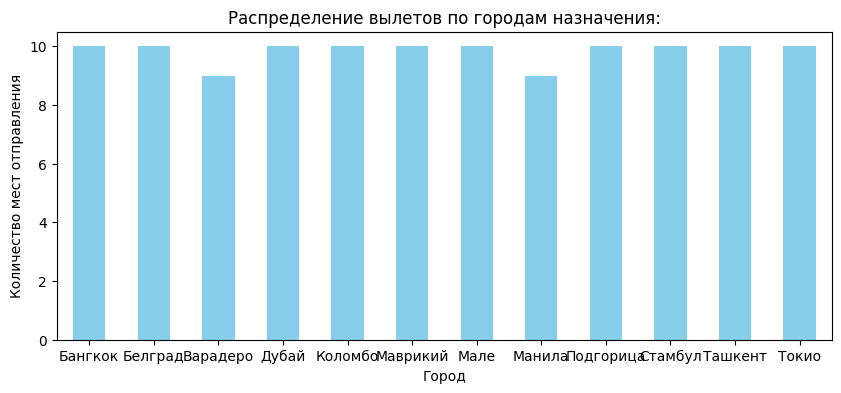

In [43]:
plt.figure(figsize=(10, 4))
df['destination_city'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Распределение вылетов по городам назначения:')
plt.xlabel('Город')
plt.ylabel('Количество мест отправления')
plt.xticks(rotation=0)
plt.show()

Анализ статистики по городам назначения показал равномерное распределение популярности среди основных направлений. Бангкок, Белград, Дубай, Коломбо, Маврикий, Мале, Стамбул, Ташкент и Токио привлекли по 10 рейсов, Варадеро и Манила — по 9.

Это указывает на широкий географический охват сервиса Aviasales, включающий как традиционные туристические центры, так и менее популярные направления. Разница в количестве рейсов незначительна, что свидетельствует об отсутствии явного фаворита.

Современные туристы активно исследуют разнообразные направления, не отдавая предпочтения одному региону или типу отдыха. Это говорит о сбалансированном предложении авиаперевозчиков и разнообразии предпочтений путешественников.

**Построим карту, на которой отобразим популярные направления** (Гипотеза 1)

In [44]:
world_map = folium.Map(location=[20, 0], zoom_start=2) # Создаём карту с заданным масштабом

cities = folium.map.FeatureGroup() # Создание группы функций для городов

# Координатами городов
city_coordinates = {
    'Коломбо': ['Шри-Ланка', [6.9271, 79.8612]],
    'Мале': ['Мальдивы', [4.1755, 73.5093]],
    'Ташкент': ['Узбекистан', [41.2995, 69.2401]],
    'Бангкок': ['Таиланд', [13.7563, 100.5018]],
    'Белград': ['Сербия', [44.7866, 20.4489]],
    'Дубай': ['ОАЭ', [25.276987, 55.296249]],
    'Стамбул': ['Турция', [41.0082, 28.9784]],
    'Манила': ['Филиппины', [14.5995, 120.9842]],
    'Подгорица': ['Черногория', [42.4411, 19.2636]],
    'Маврикий': ['Маврикий', [-20.348404, 57.552152]],
    'Токио': ['Япония', [35.6762, 139.6503]],
    'Варадеро': ['Куба', [23.1460, -81.2752]]
}

# Добавляем маркеры
for city, (country, coords) in city_coordinates.items():
    cities.add_child(
        folium.Marker(
            location=coords,
            popup=f"<b>{city}</b> {country}",
            icon=folium.Icon(color='blue', icon='info-sign')
        )
    )

world_map.add_child(cities) # Добавление объекты на карту
world_map

Анализ географического распределения направлений выявил три ключевых кластера: основная концентрация маршрутов приходится на Юго-Восточную Азию (Таиланд, Шри-Ланка) со средними ценами 15-25 тыс. руб., тогда как немногочисленные европейские направления отличаются более высокой стоимостью, а единственный американский маршрут на Кубу формирует премиальный сегмент с максимальными ценами.

**Рассмотрим соотношения типов направления и цен на авиабилеты** (Гипотеза 2)

Посмотрим на среднюю цену перелета из самых популярных городов отправления.Средняя цена города с 1-2 рейсами может быть искажена сезонными колебаниями, акциями, ошибками в данных или редкими рейсами, поэтому мы ограничим город отправления 3 и более  рейсами, что позволит работать только с устойчивыми, статистически значимыми данными

In [45]:
count_origin = df['origin_name'].value_counts()

# Фильтруем DataFrame, оставляя только те 'origin_name', которые встречаются более 2 раз
filtered_df = df[df['origin_name'].isin(count_origin[count_origin > 2].index)]

# Группировка по 'origin_name' и расчет средней цены 'price'
average_price_by_origin = filtered_df.groupby('origin_name')['price'].mean().reset_index()

# Переименуем столбец для удобства
average_price_by_origin.columns = ['origin_name', 'average_price']

print(average_price_by_origin)


        origin_name  average_price
0       Владивосток   14634.490000
1             Дубай   16877.000000
2      Екатеринбург   22749.704444
3           Иркутск   15326.246667
4            Казань   21068.366250
5        Красноярск   15492.476667
6             Минск   29739.270000
7            Москва   17101.500000
8       Новосибирск   20363.081250
9   Санкт-Петербург   22334.764167
10             Сочи   20260.125000
11          Стамбул   16300.390000
12              Уфа   19234.106667


Интересно, влияет ли город отправления на среднюю стоимость билета? Выдвинем гипотезы и проверим их с помощью **теста Краскела-Уоллиса** ,но для начала проверим нормальность с помощью **теста Шапиро-Уилка**

In [46]:
from scipy.stats import shapiro

cities = filtered_df['origin_name'].unique()

for city in cities:
    data = filtered_df[filtered_df['origin_name'] == city]['price']
    if len(data) >= 3:  # Минимум 3 наблюдения для теста
        stat, p_value = shapiro(data)
        print(f"{city}: p-value = {p_value:.4f}, n = {len(data)}")
    else:
        print(f"{city}: недостаточно данных (n = {len(data)})")

Москва: p-value = 0.4269, n = 12
Екатеринбург: p-value = 0.1487, n = 9
Уфа: p-value = 0.1286, n = 6
Санкт-Петербург: p-value = 0.3218, n = 12
Дубай: p-value = 0.4954, n = 3
Новосибирск: p-value = 0.6260, n = 8
Казань: p-value = 0.0993, n = 8
Красноярск: p-value = 0.1212, n = 3
Сочи: p-value = 0.2453, n = 8
Минск: p-value = 0.5596, n = 3
Иркутск: p-value = 0.0688, n = 3
Владивосток: p-value = 0.7938, n = 3
Стамбул: p-value = 0.0718, n = 3


Данные распределены **ненормально**. Выдвигаем гипотезы:

*   Нулевая гипотеза (Н0): Цена на авиабилеты не зависит от города отправления
*   Альтернативая гипотеза (Н1): Цена на авиабилеты зависит от города отправления



In [47]:
from scipy.stats import kruskal

# Группируем данные
groups = [filtered_df[filtered_df['origin_name'] == city]['price'] for city in cities]

# Проводим тест
stat, p_value = kruskal(*groups)
print(f"Kruskal-Wallis p-value: {p_value}")


Kruskal-Wallis p-value: 0.7729640481771651


В результате мы получили p-value = 0.7729640481771652 (>0.05), что говорит о том, мы принимаем нулевую гипотезу: Цена на авиабилеты не зависит от города отправления

*Действительно, если обратить внимание на исследуемую область (авиабилеты), то результаты теста становятся вполне понятными и логичными. Цены на авиабилеты зависят в большей мере не от города отправления, а от расстояния между городом отправления и местом назначения. В этом исследовании мы обращаем внимание на цены по городу отправления, чтобы определить, из какого крупный город отправления в целом выгоднее и проще улететь по популярным направлениям, а также рассмотреть возможность путешествий в разные по типу направления.*

Построим гистограмму, с помощью которой определим, из каких городов отправления средняя цена на перелёты ниже.

/var/folders/4h/13zr095105qfbght16k_zynw0000gn/T/ipykernel_11605/2480600027.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='origin_name', y='average_price', data=average_price_by_origin, palette=palette)


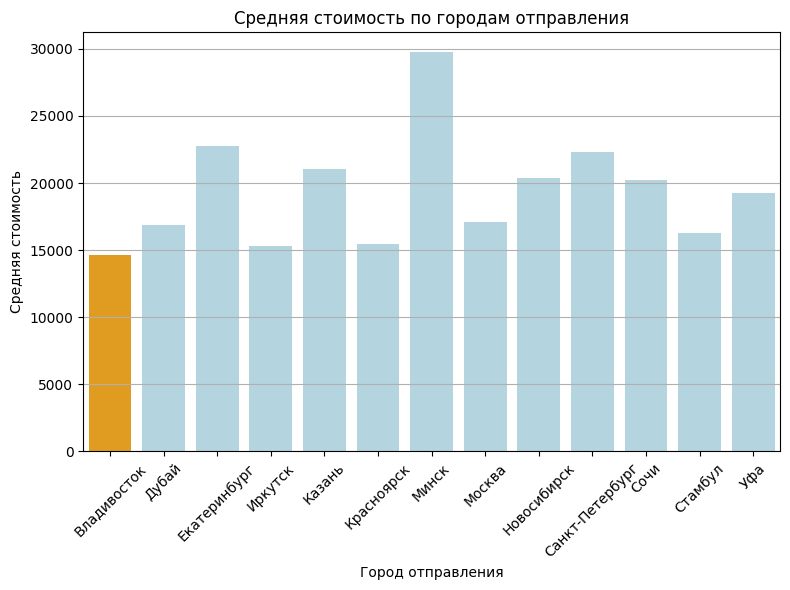

In [48]:
min_average_price = average_price_by_origin['average_price'].min() #определяем минимальный элемент, чтобы в дальнейшем окрасить его в выделяющийся цвет

plt.figure(figsize=(8, 6))
palette = ['orange' if price == min_average_price else 'lightblue' for price in average_price_by_origin['average_price']]
sns.barplot(x='origin_name', y='average_price', data=average_price_by_origin, palette=palette)
plt.title('Средняя стоимость по городам отправления')
plt.xlabel('Город отправления')
plt.ylabel('Средняя стоимость')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()


Москва, как крупнейший транспортный узел России, предлагает самые выгодные тарифы благодаря развитой инфраструктуре и большому числу перевозчиков. В регионах цены выше из-за ограниченного выбора рейсов и низкой конкуренции. Исключение составляет Минск, где цены на билеты очень высоки, что свидетельствует о проблемах с транспортной доступностью.
Города Дальнего Востока, несмотря на удаленность, имеют относительно низкие цены благодаря ориентации на азиатские направления.

Средняя стоимость перелетов из Стамбула и Дубая незначительно отличается от Москвы (менее чем на 1000 рублей). Такая разница не является статистически значимой и может быть связана с сезонными колебаниями или особенностями выборки данных.

Посмотрим на направления, в которые летают рейсы из Владивостока, чтобы убедиться в том, что низкая средняя цена на авиабилеты связана с особенностями направления:

In [49]:
# Фильтруем рейсы
vladivostok_flights = df[df['origin_name'] == 'Владивосток']

print(vladivostok_flights[['destination_city', 'destination_country', 'Type_of_rest', 'price']])

    destination_city destination_country      Type_of_rest     price
38           Бангкок             Таиланд   Городской отдых  13537.10
77            Манила           Филиппины   Городской отдых  15878.37
100            Токио              Япония  Культурный отдых  14488.00


Анализ стоимости авиабилетов из Владивостока в Бангкок (13 537 рублей), Манилу (15 878 рублей) и Токио (14 488 рублей) показывает, что Токио — самое доступное направление. Заметим, что в таблице существуем всего 3 пункта назначения из владивостока. Возможно, Токио дешевле из-за близкого расстояния (около 1000 км). Бангкок имеет среднюю цену, а Манила — самую высокую из-за меньшего количества рейсов и сложной логистики.

Владивосток отличается низкими ценами на авиабилеты в Азию, но ограничен маршрутной сетью, что делает его одним из самых выгодных городов для перелетов в азиатские страны, но стоимость в тропические и культутно-исторические направления, за исключением Токио, может быть особенно высокой из-за расположения

**Посмотрим на соотношения цен из самых популярных городов отправления в зависимости от типа направления** (Гипотеза 3)

/var/folders/4h/13zr095105qfbght16k_zynw0000gn/T/ipykernel_11605/2086635688.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='origin_name', y='price', hue='Type_of_rest', data=filtered_df, palette='Set2', ci=None)


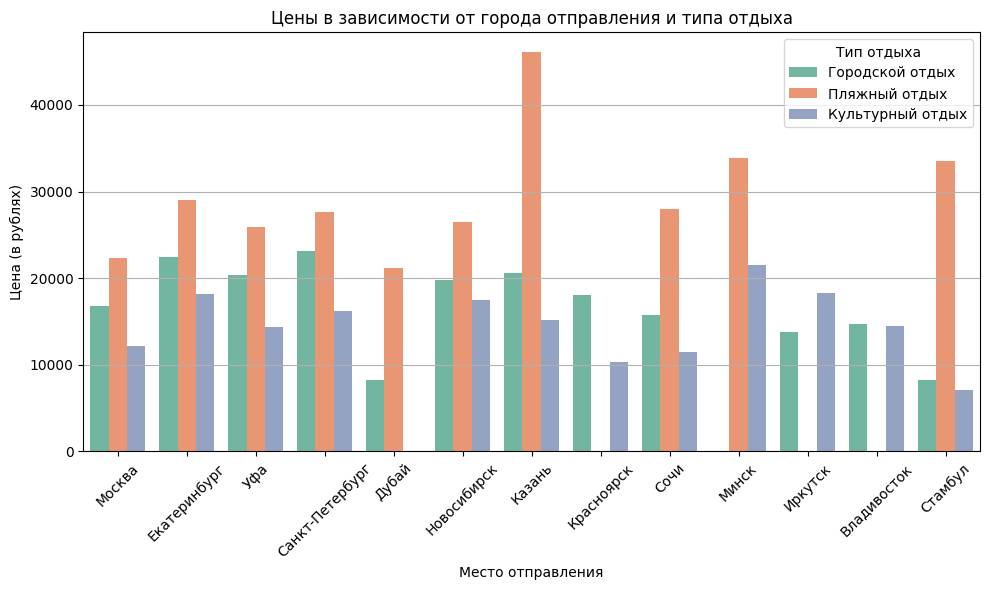

In [50]:
count_origin = df['origin_name'].value_counts()

# Фильтруем, оставляя только те origin_name, которые встречаются более 2 раз
filtered_df = df[df['origin_name'].isin(count_origin[count_origin > 2].index)]

# Построение гистограммы
plt.figure(figsize=(10, 6))
sns.barplot(x='origin_name', y='price', hue='Type_of_rest', data=filtered_df, palette='Set2', ci=None)

# Настройка графика
plt.title('Цены в зависимости от города отправления и типа отдыха')
plt.xlabel('Место отправления')
plt.ylabel('Цена (в рублях)')
plt.xticks(rotation=45)
plt.legend(title='Тип отдыха')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

Анализ цен на авиабилеты перед майскими праздниками 2025 года показывает значительные различия по городам и типам отдыха. Самые высокие тарифы в Минске и Казани из-за ограниченного количества рейсов и премиальных направлений. Москва и Иркутск предлагают одни из самых низких цен благодаря конкуренции и выгодному положению.

Пляжный отдых дороже в Казани и Минске, тогда как Дубай и Стамбул имеют низкие цены. Для культурного отдыха самые доступные варианты в Стамбуле и Сочи, а дорогие билеты в Екатеринбурге и Санкт-Петербурге. Городской отдых дешевле в Красноярске и Новосибирске, а в Иркутске цены низкие из-за близости к Азии.

Также можно заметить экстремально высокие цены на пляжный отдых в Казани и отсутствие предложений для городского отдыха в Минске. В Стамбуле низкие цены на культурные и высокие на пляжные маршруты. Москва сохраняет баланс цен благодаря разнообразию направлений.

Дополнительно посмотрим на цена в разные направления в которые существует рейсы из Москвы

In [51]:
# Фильтруем рейсы по Москве
moscow_flights = df[df['origin_name'] == 'Москва']

print(moscow_flights[['destination_city', 'destination_country', 'Type_of_rest', 'price']])

    destination_city destination_country      Type_of_rest    price
0            Коломбо           Шри-Ланка   Городской отдых  13869.0
10              Мале            Мальдивы     Пляжный отдых  18498.0
20           Ташкент          Узбекистан  Культурный отдых   6098.0
31           Бангкок             Таиланд   Городской отдых  12929.0
40           Белград              Сербия  Культурный отдых  17196.0
50             Дубай                 ОАЭ     Пляжный отдых   5110.0
60           Стамбул              Турция  Культурный отдых   5689.0
70            Манила           Филиппины   Городской отдых  22664.0
79         Подгорица          Черногория   Городской отдых  17864.0
89          Маврикий            Маврикий     Пляжный отдых  37730.0
99             Токио              Япония  Культурный отдых  19616.0
109         Варадеро                Куба     Пляжный отдых  27955.0


Москва предлагает разнообразные авиарейсы,возможно, потому что Москва является крупнейшим транспортным узлом, она имеет рейсы от ближайших культурных и городских направлений, таких как Ташкент (6 098 р.) и Стамбул (5 689 р.), до экзотических пляжных курортов, включая Мальдивы (37 730 р.). Близость и конкуренция снижают цены на ближние рейсы, тогда как дальние и премиальные направления, такие как Маврикий и Варадеро, стоят дороже из-за удалённости и ограниченного числа прямых рейсов. Тип отдыха также влияет на стоимость: пляжный отдых дороже из-за сезонного спроса, а культурный и городской — доступнее благодаря развитой инфраструктуре.

Далее подробно рассмотрим направления перелетов, средние цены на них, выдвинем гипотезы

In [52]:
# Рассчитаем средние цены
avg_price = df.groupby('Type_of_rest')['price'].mean().reset_index()
print("Средние цены по типам отдыха:\n", avg_price)

Средние цены по типам отдыха:
        Type_of_rest         price
0   Городской отдых  14402.724872
1  Культурный отдых  14386.468000
2     Пляжный отдых  25706.596923


/var/folders/4h/13zr095105qfbght16k_zynw0000gn/T/ipykernel_11605/2001950828.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type_of_rest', y='price', data=df, palette='Set2')


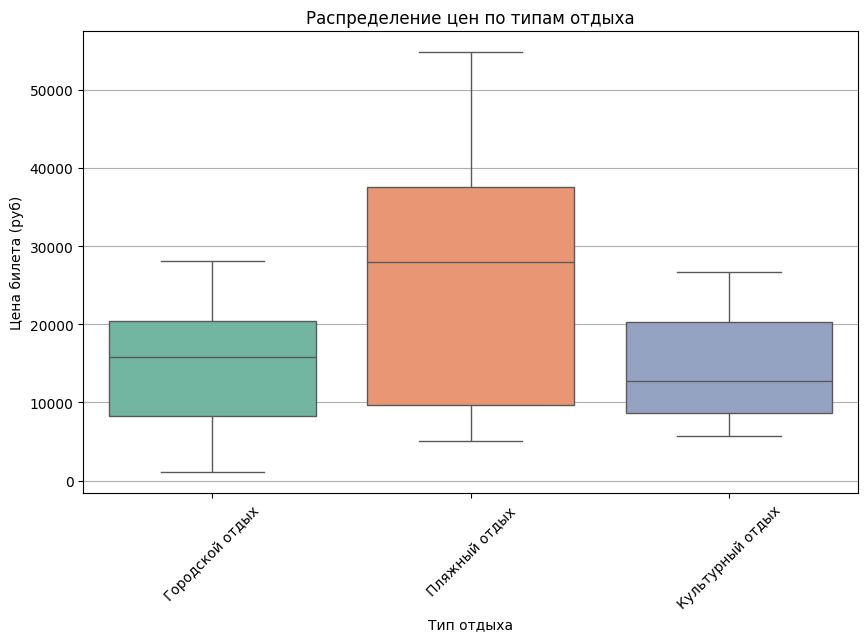

In [53]:
# Посмотрим на ящик с усами
plt.figure(figsize=(10, 6))
sns.boxplot(x='Type_of_rest', y='price', data=df, palette='Set2')
plt.title("Распределение цен по типам отдыха")
plt.xlabel('Тип отдыха')  # Исправлено с plt.ylabel
plt.ylabel('Цена билета (руб)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

**Пляжный отдых** предлагает самый широкий выбор цен и высокую медианную стоимость. Это говорит о премиальности направлений и влиянии сезонного спроса.

**Культурный отдых** отличается более компактным распределением цен с меньшим разбросом. Это характерно для популярных направлений, где авиакомпании ведут активную конкуренцию.

**Городской отдых** занимает промежуточное положение. Однако здесь встречаются экстремально высокие цены, что может быть связано с редкими рейсами в экзотические города.

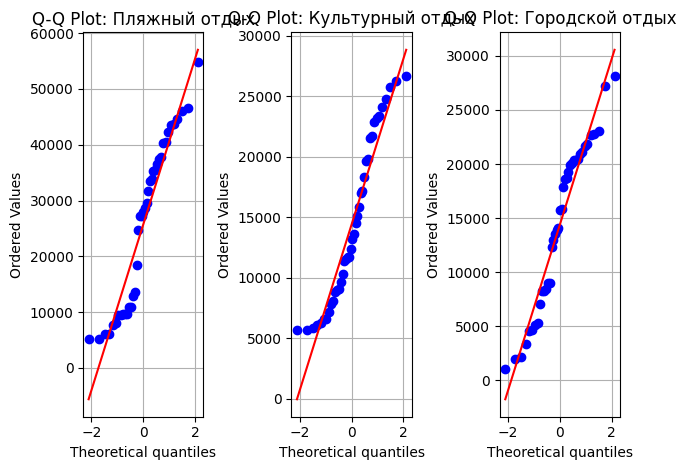

In [54]:
# Проверим нормальность распределения с помощью Q-Q графика
# Пляжный отдых
plt.subplot(1, 3, 1)
stats.probplot(df[df['Type_of_rest'] == 'Пляжный отдых']['price'], plot=plt)
plt.title('Q-Q Plot: Пляжный отдых')
plt.grid(True)

# Культурный отдых
plt.subplot(1, 3, 2)
stats.probplot(df[df['Type_of_rest'] == 'Культурный отдых']['price'], plot=plt)
plt.title('Q-Q Plot: Культурный отдых')
plt.grid(True)

# Городской отдых
plt.subplot(1, 3, 3)
stats.probplot(df[df['Type_of_rest'] == 'Городской отдых']['price'], plot=plt)
plt.title('Q-Q Plot: Городской отдых')
plt.grid(True)

plt.tight_layout()
plt.show()

Данные распределены нормально

Выдвинем гипотезы и проведем статистические тесты, будем использовать тест Краскела-Уоллиса

*    Нулевая гипотеза (H0): Различий между ценами на разные направления отсутсвуют
*   Альтернативная гипотеза (H1): Различия между ценами на разные направления существуют

In [55]:
from scipy.stats import kruskal

# Распределим данные по группам
beach = df[df['Type_of_rest'] == 'Пляжный отдых']['price']
culture = df[df['Type_of_rest'] == 'Культурный отдых']['price']
city = df[df['Type_of_rest'] == 'Городской отдых']['price']

# Проводем тест
stat, p = kruskal(beach, culture, city)
print(f"p-value = {p:.4f}")


p-value = 0.0008


Результаты теста Краскела-Уоллиса показали p-value = 0.0008 (< 0.05), поэтому мы отвергаем нулевую гипотезу и принимаем альтернативную: **различия между ценами на разные направления существуют**

Далее нам нужно понять какой именно тип отдыха отличается и как, проведем попарные сравнения с поправкой Бонферрони:

*   Нулевая гипотеза (Н0): Нет различий в ценах между пляжным и культурным отдыхом/ Нет различий в средних ценах между пляжным и городским отдыхом
*   Альтернативная гипотеза (Н1): Существуют различия в ценах между пляжным и культурным отдыхом/ Существуют различия в средних ценах между пляжным и городским отдыхом (цена на пляжный отдых выше)



In [56]:
# Сравним пляжный и культурный отдых
t1, p1 = ttest_ind(
    df[df['Type_of_rest'] == 'Пляжный отдых']['price'],
    df[df['Type_of_rest'] == 'Культурный отдых']['price'],
    equal_var=False)

# Сравним пляжный и культурный отдых
t2, p2 = ttest_ind(
    df[df['Type_of_rest'] == 'Пляжный отдых']['price'],
    df[df['Type_of_rest'] == 'Городской отдых']['price'],
    equal_var=False)
# Поправка Бонферрони
p_values = [p1, p2]
_, p_corrected, _, _ = multipletests(p_values, method='bonferroni')

print(f"1. пляжный и культурный отдых: p-value = {p_corrected[0]:.4f}")
print(f"2. пляжный и городской отыдх: p-value = {p_corrected[1]:.4f}")

1. пляжный и культурный отдых: p-value = 0.0001
2. пляжный и городской отыдх: p-value = 0.0002


Результат показал, p-value меньшее 0.05 в обоих случаях, что указывает на то, что пляжный отдых является самым дорогим, скорее всего, это связано с тем, что многие пляжные направления, особенно экзотические, расположены далеко и требуют длительных перелётов с ограниченным числом прямых рейсов, что увеличивает стоимость путешествия

Следующим дейсвтием сравним цены на культурно-исторический отдых и городской:


*   Нулевая гипотеза (H0): Нет различий в ценах между культурным и городским отдыхом
*   Альтернативная гипотеза (H1): Существуют различия в ценах между культурным и городским отдыхом (цены на культурный отдых ниже)



In [57]:
# Сравнение культурного и городского отдыха
t_stat, p_value = ttest_ind(df[df['Type_of_rest']=='Культурный отдых']['price'],
                           df[df['Type_of_rest']=='Городской отдых']['price'],
                           equal_var=False)
print(f"p-value: {p_value:.5f}")

p-value: 0.99208


Результат показал p-value = 0.99208, что больше 0.05, мы принимаем нулевую гипотезу: Нет различий в ценах между культурным и городским отдыхом

***Вывод:*** цены на пляжный отдых выше, чем на городской и культурно-исторический. На майские праздники авиабилеты для пляжных направлений стоят дороже из-за популярности курортов, таких как Мале, Варадеро, Маврикий и Дубай. Эти направления находятся далеко и доступны только ограниченным числом прямых рейсов, что увеличивает время и стоимость перелета.
Культурно-исторические и городские маршруты дешевле из-за развитой транспортной инфраструктуры и большего числа бюджетных рейсов.

Далее посмотрим на круговую диаграмму, чтобы более подробно и понятно увидеть предпочтения клиентов в типе отдыха

Text(0.5, 1.0, 'Распределение типов отдыха')

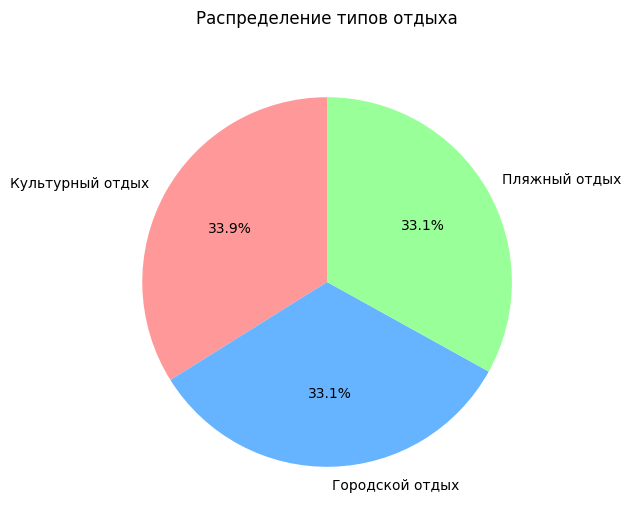

In [58]:
counts = df['Type_of_rest'].value_counts()
# Визуализируем
plt.figure(figsize=(8, 6))
plt.pie(counts,
        labels=counts.index,
        autopct='%1.1f%%',  # Формат процентов (1 знак после запятой)
        startangle=90,
        colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Распределение типов отдыха', pad=20)


Во время майских праздников путешественники  выбирают направления для перелётов почти равномерно: 33,9% предпочитают культурные поездки, 33,1% — городской отдых, а ещё 33,1% выбирают пляжные курорты. Этот баланс показывает, что в этот короткий период у путешественников широкий спектр интересов. Одни хотят погрузиться в культуру и посетить экскурсии, другие — насладиться комфортом городского отдыха, сочетая развлечения с осмотром достопримечательностей, а третьи ищут расслабление на пляже. Такое распределение также свидетельствует о разнообразии предложений на рынке и доступности разных направлений.

Следующим шагом разобъем города отправления на группы и посмотрим, существует ли связь между пунктом отправления и предпочитаемым направлением отдыха

In [59]:
def get_geo_group(city):
    groups = {
        'Дальний Восток': ['Владивосток', 'Хабаровск'],
        'Урал': ['Екатеринбург', 'Уфа', 'Тюмень', 'Пермь', 'Челябинск'],
        'Сибирь': ['Иркутск', 'Красноярск', 'Новосибирск', 'Омск', 'Томск', 'Барнаул'],
        'Центральная Россия': ['Москва', 'Казань', 'Нижний Новгород', 'Самара', 'Воронеж',
                              'Ярославль', 'Тула', 'Рязань', 'Смоленск', 'Тверь', 'Иваново'],
        'Северо-Запад': ['Санкт-Петербург', 'Калининград', 'Мурманск', 'Архангельск',
                        'Петрозаводск', 'Великий Новгород', 'Псков'],
        'Юг России': ['Сочи', 'Волгоград', 'Махачкала', 'Минеральные Воды',
                     'Владикавказ', 'Ставрополь', 'Краснодар', 'Ростов-на-Дону', 'Астрахань'],
        'Международные': ['Дубай', 'Абу-Даби', 'Мале', 'Бангкок', 'Коломбо', 'Сингапур',
                         'Минск', 'Пхукет', 'Стамбул', 'Эль-Нидо', 'Себу', 'Катиклан',
                         'Гонконг', 'Барселона', 'Баку', 'Вена', 'Белград', 'Астана',
                         'Пекин', 'Шанхай', 'Канкун', 'Пунта-Кана', 'Санто-Доминго', 'Мехико']
    }
    for group, cities in groups.items():
        if city in cities:
            return group
    return 'Другие'

# Применяем функцию к DataFrame
df['geo_group'] = df['origin_name'].apply(get_geo_group)

# Проверяем результат
print(df[['origin_name', 'geo_group', 'price']].sort_values('geo_group'))

     origin_name       geo_group     price
77   Владивосток  Дальний Восток  15878.37
100  Владивосток  Дальний Восток  14488.00
38   Владивосток  Дальний Восток  13537.10
37     Хабаровск  Дальний Восток  18638.17
106    Хабаровск  Дальний Восток  16982.00
..           ...             ...       ...
53          Сочи       Юг России   6093.00
52     Махачкала       Юг России   5117.00
51     Волгоград       Юг России  10864.00
15          Сочи       Юг России  24673.00
28          Сочи       Юг России  12396.00

[118 rows x 3 columns]


Созданим кросс-таблицу с процентным распределением типов отдыха (пляжный, культурный, городской) по географическим группам

In [60]:
cross_tab = pd.crosstab(
    index=df['geo_group'],
    columns=df['Type_of_rest'],
    normalize='index'
).round(3) * 100

print("Распределение типов отдыха по группам (%):")
print(cross_tab)

Распределение типов отдыха по группам (%):
Type_of_rest        Городской отдых  Культурный отдых  Пляжный отдых
geo_group                                                           
Дальний Восток                 60.0              40.0            0.0
Международные                  45.5              12.1           42.4
Северо-Запад                   33.3              33.3           33.3
Сибирь                         42.9              42.9           14.3
Урал                           18.8              50.0           31.2
Центральная Россия             30.4              43.5           26.1
Юг России                       6.7              40.0           53.3


На основе данных о предпочтениях отдыха в майские праздники выявлены значительные региональные различия. На Дальнем Востоке преобладает городской отдых (*60%*), пляжный не популярен (*0%*). На Юге России лидирует пляжный отдых (*53,3%*), что обусловлено доступностью курортов и климатом. Международные направления демонстрируют равный спрос на городской (*45,5%*) и пляжный отдых (*42,4%*), культурный менее популярен (*12,1%*). В регионах с равномерным распределением (Северо-Запад, Сибирь) туристы выбирают городской и культурный отдых (*33,3%*), а на Урале и в Центральной России преобладает культурный отдых (*50%* и *43,5%*). Это связано с развитой инфраструктурой познавательного туризма. Распределение предпочтений зависит от географии, доступности направлений и местных особенностей, что важно учитывать при разработке туристических стратегий.

Визуализируем эти данные, используя тепловую карту

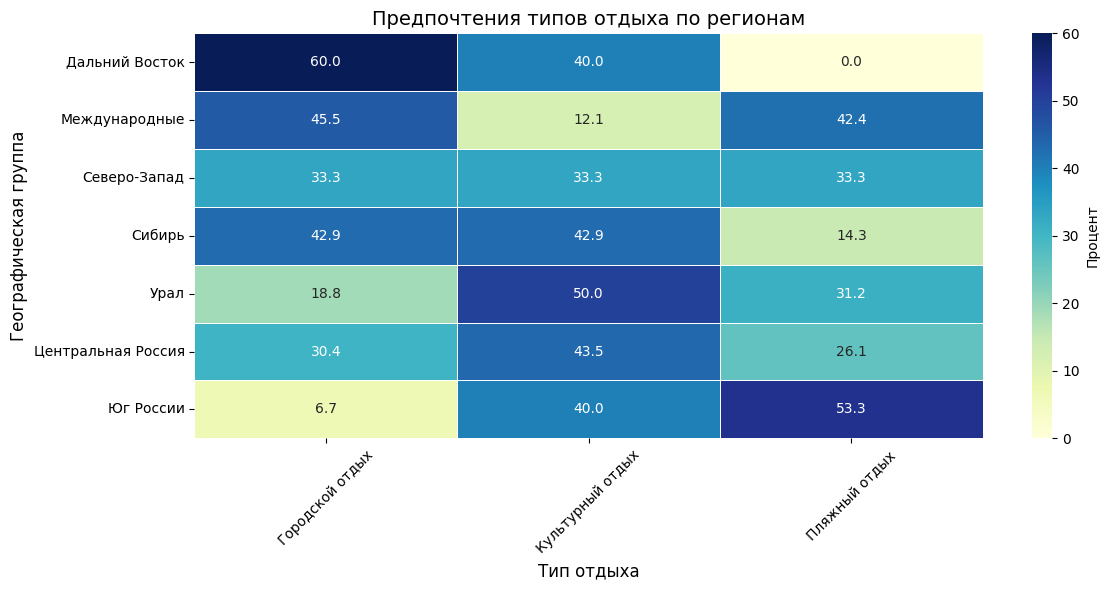

In [61]:
plt.figure(figsize=(12, 6))
sns.heatmap(
    cross_tab,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={'label': 'Процент'}
)

plt.title("Предпочтения типов отдыха по регионам", fontsize=14)
plt.xlabel("Тип отдыха", fontsize=12)
plt.ylabel("Географическая группа", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Можно наблюдать зависимость между типом предпочитаемого отдыха и местом отправления, проверим есть ли действительно эта зависимость с помощью теста хи-квадрат. Выдвинем гипотезы:

*   Нулевая гипотеза (H0):Тип предпочитаемого отдыха не зависит от региона отправления
*   Альтернативная гипотеза (Н1):Тип предпочитаемого отдыха зависит от региона отправления



In [62]:
from scipy.stats import chi2_contingency
import numpy as np
observed = np.array([
    [60, 40, 0],      # Дальний Восток
    [45.5, 12.1, 42.4], # Международные
    [33.3, 33.3, 33.3], # Северо-Запад
    [42.9, 42.9, 14.3], # Сибирь
    [18.8, 50.0, 31.2], # Урал
    [30.4, 43.5, 26.1], # Центральная Россия
    [6.7, 40.0, 53.3]   # Юг России
])

chi2_stat, p_value, dof, expected = chi2_contingency(observed)

# Вывод результатов
print("Результаты теста хи-квадрат:")
print(f"Статистика хи-квадрат: {chi2_stat:.2f}")
print(f"p-value: {p_value:.5f}")  # Увеличена точность до 5 знаков
print(f"Степени свободы: {dof}")


Результаты теста хи-квадрат:
Статистика хи-квадрат: 144.11
p-value: 0.00000
Степени свободы: 12


Результаты хи-теста показали Статистика хи-квадрат: 144.11 и p-value: 0.0000 ( < 0,05), поэтому мы отвергаем нулевую гипотезу и принимаем альтернативную:Тип предпочитаемого отдыха зависит от региона отправления. Предположим на основе данных о регионах с чем это может быть связано:

* Дальний Восток: Географическое положение делает пляжный отдых, например, на Мальдивах или в Таиланде, невыгодным. Длительные перелёты с пересадками через Москву или другие хабы значительно увеличивают стоимость поездки. К тому же, прохладный майский климат не способствует расслаблению на пляже. Вместо этого жители региона предпочитают городские направления, такие как Токио и Сеул, где мягкая весна идеально подходит для экскурсий и шопинга. Развитый деловой туризм также формирует привычку к урбанистическому отдыху — многие совмещают рабочие поездки с коротким отпуском.

* Юг России: туристы привыкли к традиционным курортам, таким как Сочи и Крым, стимулирует интерес к экзотике. Туристы выбирают Дубай или Мальдивы как более престижные альтернативы. Близость к Турции и ОАЭ делает пляжный отдых доступным даже для коротких майских каникул. Культурные поездки в Стамбул и Ташкент также популярны благодаря историческим связям региона. Многие жители Юга России посещают музеи, мечети и рынки, что напоминает им о культурной близости.

* Северо-Запад: Высокий уровень доходов и статус Санкт-Петербурга как культурной столицы создают широкий выбор направлений. Удобное транспортное сообщение через аэропорт Пулково позволяет легко добраться до пляжных курортов, таких как Дубай и Анталья, а также до европейских культурных центров, таких как Вена и Белград, и азиатских мегаполисов, таких как Бангкок и Сеул. Разнообразие интересов — от гастрономических туров в Стамбул до отдыха на Мальдивах — поддерживает равномерный спрос на различные виды отдыха.

* Сибирь: Умеренный интерес к пляжам объясняется необходимостью акклиматизации. Резкий переход от сибирской весны к тропической жаре может быть дискомфортным для многих туристов. Вместо этого жители региона часто выбирают городской отдых в Бангкоке или Коломбо, где можно сочетать шопинг, экскурсии и мягкий климат. Прямые рейсы из Новосибирска и Красноярска делают азиатские направления доступными.

* Урал: Исторический туризм сосредоточен на Европе, таких как Прага и Вена, а также на городах Золотого кольца России. Это отражает интерес к культурному наследию. Пляжный отдых ограничивается бюджетными направлениями, такими как Турция. Деловая активность в Екатеринбурге и Челябинске снижает спрос на городские туры — жители чаще отправляются в командировки, чем в отпуск.

* Центральная Россия: Многообразие направлений из московских аэропортов, таких как Шереметьево и Домодедово, позволяет туристам выбирать между европейскими культурными центрами, такими как Париж и Рим, ближневосточными курортами, такими как Дубай и Шарм-эль-Шейх, а также экзотическими пляжами, такими как Мальдивы и Сейшелы. Премиум-сегмент отдыха, например, виллы на Мальдивах, популярен среди состоятельных москвичей. Бюджетные путешественники чаще выбирают Стамбул или Ташкент.




## Выводы

Анализ цен на авиабилеты и туристических предпочтений в майские праздники показывает, что рынок авиабилетов отличается высокой изменчивостью и разнообразием направлений. Средняя стоимость билета составляет около 18 тысяч рублей, а **диапазон цен варьируется от бюджетных перелётов до премиальных маршрутов**. Это отражает разницу в дальности и специфике спроса на определённые направления. Данные свидетельствуют о сбалансированном распределении цен и корректности выборки.

**Самым популярным направлением среди российских туристов становится Коломбо (Шри-Ланка)**. Здесь комфортный климат, развитая инфраструктура, удобное авиасообщение и возможность совместить пляжный отдых с экскурсионной программой. Туристы также выбирают тропические курорты, культурно-исторические направления и классические пляжные локации. Это говорит о стремлении к разнообразию впечатлений и новых открытий.

**Москва традиционно занимает лидирующие позиции по количеству маршрутов и разнообразию направлений**. Это главный авиационный хаб страны с развитой инфраструктурой, большим числом прямых рейсов и высокой конкуренцией авиакомпаний. В регионах цены на билеты часто выше из-за ограниченного предложения и низкой конкуренции.**В некоторых городах, таких как Минск, стоимость перелётов увеличивается из-за проблем с транспортной доступностью. Города Дальнего Востока, несмотря на удалённость, демонстрируют относительно низкие цены на направления в Азию благодаря географическому положению, хотя маршрутная сеть там ограничена**.

Статистический анализ показал, что **цены на авиабилеты не зависят от города отправления, но тип отдыха и региональные особенности влияют на выбор направления и структуру спроса, который влияет на ценообразование**. Пляжные направления обычно самые дорогие из-за удалённости, ограниченного числа прямых рейсов и высокого сезонного спроса. Культурно-исторические и городские маршруты доступнее благодаря развитой транспортной инфраструктуре.

Распределение предпочтений по типам отдыха практически равномерное: **треть туристов выбирает культурные поездки, треть — городской отдых, ещё треть — пляжные курорты. Это свидетельствует о широких интересах российских путешественников и разнообразии предложений на рынке**. Региональные различия остаются значимыми: на Дальнем Востоке преобладает городской отдых, на Юге России — пляжный, а в Центральной России и на Урале чаще выбирают культурные маршруты. Такие особенности объясняются географией, транспортной доступностью, климатическими условиями и экономическими факторами.

Майские праздники становятся временем активных путешествий. Россияне стремятся использовать короткий отпуск разнообразно — от экскурсий по историческим городам до отдыха на экзотических пляжах. Для туристического бизнеса это открывает возможности для формирования гибких предложений, учитывающих региональные предпочтения и структуру спроса.


**На основе нашего анализа мы собрали основные советы для туристов, которые планируют отдых в мае 2026 года:**

1. Выбирайте направления с учётом продолжительности отдыха и
удобства перелётов. Майские праздники обычно длятся от 4 до 8 дней. Выбирайте города с прямыми рейсами и коротким временем в пути, такие как Стамбул, Ташкент или Дубай. Это позволит сэкономить время и силы, избежать утомительных пересадок и максимально насладиться отдыхом.

2. Комбинируйте город и пляж. Многие туристы хотят сочетать культурный отдых с пляжным. Например, начните с Стамбула или Коломбо, а затем отправляйтесь на Мальдивы или Шри-Ланку. Это разнообразит впечатления, сделает отдых интереснее, а траты на него при граммотном выборе места отлета, прилета и типе отдыха будут незначительными.

3. Изучите внутренние направления. Май — отличное время для путешествий по России. Кавказские Минеральные Воды, Алтай, Байкал и Санкт-Петербург предлагают комфортный климат, уникальные природные красоты и насыщенную культурную программу. Здесь не нужно оформлять визу и тратить много денег на перелёт.

4. Планируйте поездку заранее. В мае популярны как пляжные, так и культурные направления. Цены могут быстро расти, особенно на пляжный отдых. Раннее бронирование и гибкий подход к выбору дат помогут найти выгодные предложения. Учитывайте, откуда вы будете вылетать. Например, если вы живёте на Дальнем Востоке, рассмотрите Азию или Филиппины. Если на юге — выбирайте пляжный отдых.


## Обсуждение

**Что вы хотели сделать в рамках вашего исследования и что сделать удалось:**

* Проанализировали расположение популярных туристических направлений на карте мира, чтобы визуализировать их географическую доступность и маршруты. (Удалось выполнить)

* Исследовали, как тип отдыха (городской, пляжный, культурный) влияет на цены авиабилетов. Это помогло выяснить, есть ли существенные различия в стоимости перелётов в зависимости от выбранного типа отдыха. (Удалось выполнить)

* Определили структуру цен на авиабилеты для разных типов направлений в зависимости от города отправления. Анализ показал, какие крупные города России и зарубежья наиболее выгодны для путешественников с точки зрения цен на билеты в разные направления. (Удалось выполнить)

**Что сделать не удалось и почему:**


*  Изначально мы хотели анализировать динамику изменения цен на билеты в разные периоды (зима, весна). Но мы не смогли спарсить эти данные с авиасейлс, так как их сайт блокировал запросы. Через api тоже не получилось достать интересующие нас данные, так как их было слишком мало для анализа. Поэтому мы перешли на другие данные и изменили идею проекта

**Как ваше исследование можно было бы улучшить:**


*   Добавить сезонную динамику цен, например, как меняются цены в Новогодние каникулы, в сезон летних отпусков и в обычные календарные рабочие дни.
*   Добавить данные о ценах в пунктах назначения, тогда можно было бы сделать полный анализ, в котором рассматривалась бы не только стоимость перелета, но и проживание, бронирование отеля, еда и другие факторы.




**Кому ваше исследование может быть полезно (или что можно сделать дополнительно, чтобы оно было полезным):**
* Туроператорам и турагентствам - для формирования региональных предложений, учитывающих предпочтения путешественников (например, акцент на пляжные туры для Юга России и городские направления для Дальнего Востока).
* Туристам исследование даст понимание, когда и где выгоднее бронировать билеты. Например, пляжные направления дороже в мае, а цены на городские туры стабильны. Также можно узнать популярные направления в своём регионе. Например, жителям Дальнего Востока проще и дешевле лететь в Азию, а южанам — в ОАЭ или Турцию. Это поможет избежать переплат, особенно в городах с завышенными ценами из-за низкой конкуренции авиакомпаний.